## Experiment results

1. Cross entropy loss, stratified CV, no fmix, cutmix, mixup, no gradient scaling or accumulation
2. Add gradient scaling and accumulation
3. Add smoothed cross entropy loss
4. Add *mixes



In [10]:
package_paths = [
    '../pytorch-image-models',
]
import sys; 

for pth in package_paths:
    sys.path.append(pth)

In [4]:
import os
from glob import glob
from datetime import datetime
import time
import random
from tqdm import tqdm
import warnings
import joblib
import warnings
from config import Config # my configurations file with hyperparams and constants

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2

import sklearn
from sklearn.model_selection import GroupKFold, StratifiedKFold
from skimage import io
from scipy.ndimage.interpolation import zoom
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score
from sklearn import metrics

import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

import timm # pytorch-image-models implementations: https://github.com/rwightman/pytorch-image-models

ModuleNotFoundError: No module named 'cv2'

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

NameError: name 'torch' is not defined

In [4]:
train = pd.read_csv(Config.train_img_dir)

if Config.debug:
    train = train.sample(n=100, random_state=Config.seed).reset_index(drop=True)
    Config.epochs = 1
    
train.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [ ]:
label_map = pd.read_json(Config.data_dir + '/label_num_to_disease_map.json', orient='index')
label_map

Since the distribution of classes is uneven, we could do stratified k-fold cross validation to make each fold's train and validation distributions representative of the original distributions.

In [5]:
train.label.value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

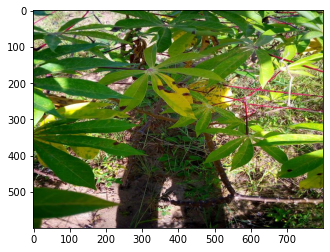

In [6]:
def set_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_seeds(Config.seed)
    
def get_image(path):
    img_bgr = cv2.imread(path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    # im_rgb = im_bgr[:, :, ::-1] would also work -> select all x, y, and reverse the color channels
    return img_rgb

sample_img = get_image(Config.train_img_dir + '/1000015157.jpg')
plt.imshow(sample_img)
plt.show()

## Dataset class

Todo ideas: add cutmix, fmix, mixup


In [7]:
class CassavaDataset(Dataset):
    def __init__(self, df, data_root_dir, transform=None, output_label=False):
        self.df = df.reset_index(drop=True).copy()
        self.data_root_dir = data_root_dir
        self.transform = transform
        self.output_label = output_label
        self.labels = self.df.label.values
 
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img = get_image('{}/{}'.format(self.data_root_dir, self.df.image_id[idx]))
        
        if self.transform:
             img = self.transform(image=img)['image']
                
        if self.output_label == True:
            return img, self.labels[idx]
        else:
            return img

#### Test it out

0 (600, 800, 3) 0
1 (600, 800, 3) 3


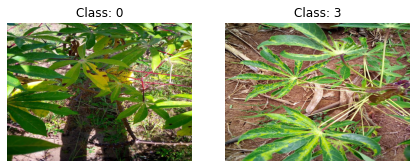

In [8]:
cassava_dataset = CassavaDataset(train, Config.train_img_dir, output_label=True)
fig = plt.figure()
for i in range(2):
    img, target = cassava_dataset[i]
    print(i, img.shape, target)
    
    ax = plt.subplot(1, 2, i + 1)
    plt.tight_layout()
    ax.set_title('Class: {}'.format(target))
    ax.axis('off')
    plt.imshow(img)
    if i == 3:
        plt.show()
        break

## Stratified Cross Validation Folds

In [9]:
train_folds = train.copy()
stratifiedFold = StratifiedKFold(n_splits=Config.fold_num, shuffle=True, random_state=Config.seed)
splits = stratifiedFold.split(np.zeros(len(train_folds)), train_folds[Config.target_col])

# label all rows of train_folds with a particular validation set fold number they are part of 
# (to select the row for validation when splitting on that fold)
for fold_num, (train_idxs, val_idxs) in enumerate(splits):
    train_folds.loc[val_idxs, 'fold'] = fold_num

train_folds['fold'] = train_folds['fold'].astype(int)
train_folds.head()

,image_id,label,fold
0,1000015157.jpg,0,2
1,1000201771.jpg,3,2
2,100042118.jpg,1,0
3,1000723321.jpg,1,2
4,1000812911.jpg,3,4


In [10]:
# verify distributions
train_folds.groupby(['fold', 'label']).count()

image_id
fold label          
0    0           218
     1           438
     2           477
     3          2631
     4           516
1    0           218
     1           438
     2           477
     3          2631
     4           516
2    0           217
     1           438
     2           477
     3          2632
     4           515
3    0           217
     1           438
     2           477
     3          2632
     4           515
4    0           217
     1           437
     2           478
     3          2632
     4           515

## Define Train\Validation Image Augmentations

In [11]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)

from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    image_size = Config.img_size
    return Compose([
            RandomResizedCrop(image_size, image_size),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.)
  
        
def get_valid_transforms():
    image_size = Config.img_size
    return Compose([
            CenterCrop(image_size, image_size, p=1.),
            Resize(image_size, image_size),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

## Model

EfficientNet noisy student: https://arxiv.org/pdf/1911.04252.pdf. Implementation from
https://github.com/rwightman/pytorch-image-models.

In [12]:
class Model(torch.nn.Module):
    def __init__(self, model_arch, n_classes, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        # replace classifier with a Linear in_features->n_classes layer
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, n_classes)
        
    def forward(self, x):
        return self.model(x)

## Loss function 

Ideas:
- https://ai.googleblog.com/2019/08/bi-tempered-logistic-loss-for-training.html
- https://github.com/mlpanda/bi-tempered-loss-pytorch/blob/master/bi_tempered_loss.py
- https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/173733

In [13]:
# reference: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/173733
class SmoothedCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean'):
        super().__init__(weight=weight, reduction=reduction)
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        lsm = F.log_softmax(inputs, -1)

        if self.weight is not None:
            lsm = lsm * self.weight.unsqueeze(0)

        loss = -(targets * lsm).sum(-1)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [14]:
class BiTemperedLoss():
    def __init__(self):
        pass
    
    def forward(self, inputs, targets):
        pass

## Training and Validation Functions

gradient scaling https://pytorch.org/docs/stable/notes/amp_examples.html

gradient accumulation https://towardsdatascience.com/what-is-gradient-accumulation-in-deep-learning-ec034122cfa

In [ ]:
def init_logger(log_file=Config.save_dir + 'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    
    # StreamHandler: sends logging output to a stream, in this case the log_file
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    
    # FileHandler: opens, closes file, sends logging output to the file
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

In [ ]:
# loops over data
def train_epoch(dataloader, model, criterion):
    pass

def valid_epoch():
    pass


'''
    Trains the model over epochs for a given fold
    
    train_folds_df: the dataset with a column for fold number
    fold: an integer representing the fold used for validation
    
    Returns a DataFrame consisting of only the the rows used for validation along with the model's predictions
''' 
def train_fold(train_folds_df, fold: int):
    # -------- DATASETS AND LOADERS --------
    train_idx = train_folds_df[train_folds_df['fold'] != fold].index  
    valid_idx = train_folds_df[train_folds_df['fold'] == fold].index 
    train_df = train_folds_df.iloc[train_idx].reset_index(drop=True) # since we are selecting rows, the index will be missing #s so reset
    valid_df = train_folds_df.iloc[valid_idx].reset_index(drop=True)
    
    train_dataset = CassavaDataset(train_df, Config.train_img_dir, output_label=True, transform=get_train_transforms())
    valid_dataset = CassavaDataset(valid_df, Config.train_img_dir, output_label=True, transform=get_valid_transforms())
    
    train_dataloader = DataLoader(train_dataset, batch_size=Config.train_bs, 
                                  pin_memory=True, shuffle=True, 
                                  num_workers=Config.num_workers)
    valid_dataloader = DataLoader(valid_dataset, batch_size=Config.valid_bs, 
                                  pin_memory=True, shuffle=False, 
                                  num_workers=Config.num_workers)
    
    
    # -------- MODEL INSTANTIATION --------
    model = Model(Config.model_arch'], train_df.label.nunique(), pretrained=True).to(device)
    
    # -------- OPTIMIZER --------
    optimizer = optim.Adam(model.parameters(), Config.lr, weight_decay=Config.weight_decay, amsgrad=Config.is_amsgrad) # try amsgrad?
    
    # -------- SCHEDULER --------
    scheduler = None
    if Config.scheduler == 'ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, factor=Config.factor, patience=Config.patience, eps=Config.eps, verbose=True)
    elif Config.scheduler == 'CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=Config.T_max, eta_min=Config.min_lr, verbose=True)
    elif Config.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=Config.T_0, T_mult=Config.T_mult, eta_min=Config.min_lr, verbose=True)
    
    # -------- SCORES --------
    best_accuracy = 0.
    
    
    for e in range(Config.epochs):
        epoch_start_time = time.time()
        
        # -------- TRAIN --------
        average_training_loss = train_epoch(train_dataloader, model, criterion)
        
        # -------- VALIDATE --------
        avg_validation_loss, preds = valid_epoch(valid_dataloader, model, criterion)
        
        epoch_elapsed_time = time.time() - epoch_start_time

        # -------- SCORE METRICS & LOGGING FOR THIS EPOCH --------
        validation_labels = valid_df[Config.target_col].values
        accuracy = accuracy_score(y_true=validation_labels, y_pred=preds)
        
        LOGGER.info(f'Epoch: {e+1} | Epoch time: {epoch_elapsed_time}\n' + \ 
            f'Training loss: {average_training_loss} | Validation loss: {avg_validation_loss} | Accuracy: {accuracy}')
        
        if accuracy > best_accuracy: # SAVE MODEL
            best_accuracy = accuracy
            torch.save({'model': model.state_dict(), 'preds': predictions},
                      Config.save_dir + f'{Config.model_name}_fold{fold}.pth')
            LOGGER.info(f'Saved model on epoch {e+1} with accuracy score {accuracy:.3f}')
        
        # -------- UPDATE LR (POTENTIALLY) --------
        if Config.scheduler == 'ReduceLROnPlateau':
            scheduler.step(avg_validation_loss)
        elif Config.scheduler == 'CosineAnnealingLR' or Config.scheduler == 'CosineAnnealingWarmRestarts':
            scheduler.step()
        
    checkpoint = torch.load(Config.save_dir + f'{Config.model_name}_fold{fold}.pth')
    valid_folds['prediction'] = checkpoint['preds'].argmax(axis=1) # take max of each row in preds (preds: rows of probabilities for each label)
    return valid_folds

## Main loop

In [ ]:
def get_result(result_df):
    preds = result_df['preds'].values
    labels = result_df[Config.target_col].values
    score = accuracy_score(y_true=labels, y_pred=preds)
    LOGGER.info(f'Score: {score:<.5f}')

In [ ]:
def main():
    if Config.train:
        aggregated_output_df = pd.DataFrame()
        
        for fold in range(Config.fold_num):
            _df = train_fold(train_folds, fold)
            Logger.info(f"train_fold() output df shape: {_df.shape}")
            aggregated_output_df = pd.concat([aggregated_output_df, _df])
            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(aggregated_output_df)
            
        # Cross validation
        LOGGER.info(f"========== CV ==========")
        get_result(aggregated_output_df)
        # Save result
        aggregated_output_df.to_csv(Config.save_dir'] + 'aggregated_output_df.csv', index=False)
        
    if Config.inference']:
        pass

In [ ]:
if __name__ == '__main__':
    main()